In [79]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from skimage.segmentation import watershed, slic, join_segmentations, flood, flood_fill
from skimage.filters import rank, sobel
from scipy import ndimage as ndi
from copy import copy
import tifffile as tiff

In [80]:
dome = str(60)

image = sk.io.imread('./../ppujol/cellstosegment/'+dome+'/tp0006-gamma-BAndC.tif')

(606, 690, 574)

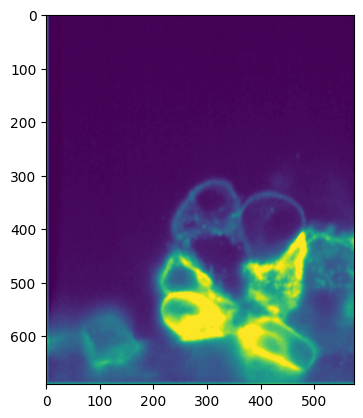

In [81]:
plt.imshow(image[150])
image.shape

In [82]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

(240, 240, 240)

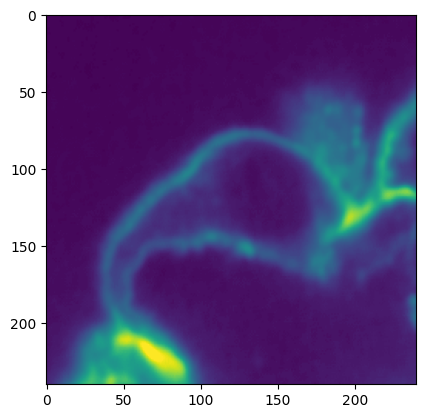

In [83]:
# z, y, x = 183, 300, 300
z, y, x = 183, 337, 300
delta = 120
# delta = 80
division = 1
cell = image[z-int(delta/division):z+int(delta/division), y-delta:y+delta, x-delta:x+delta]
cell = normalize_image(cell, 255).astype(np.uint8)
plt.imshow(cell[int(delta/division)])
cell.shape

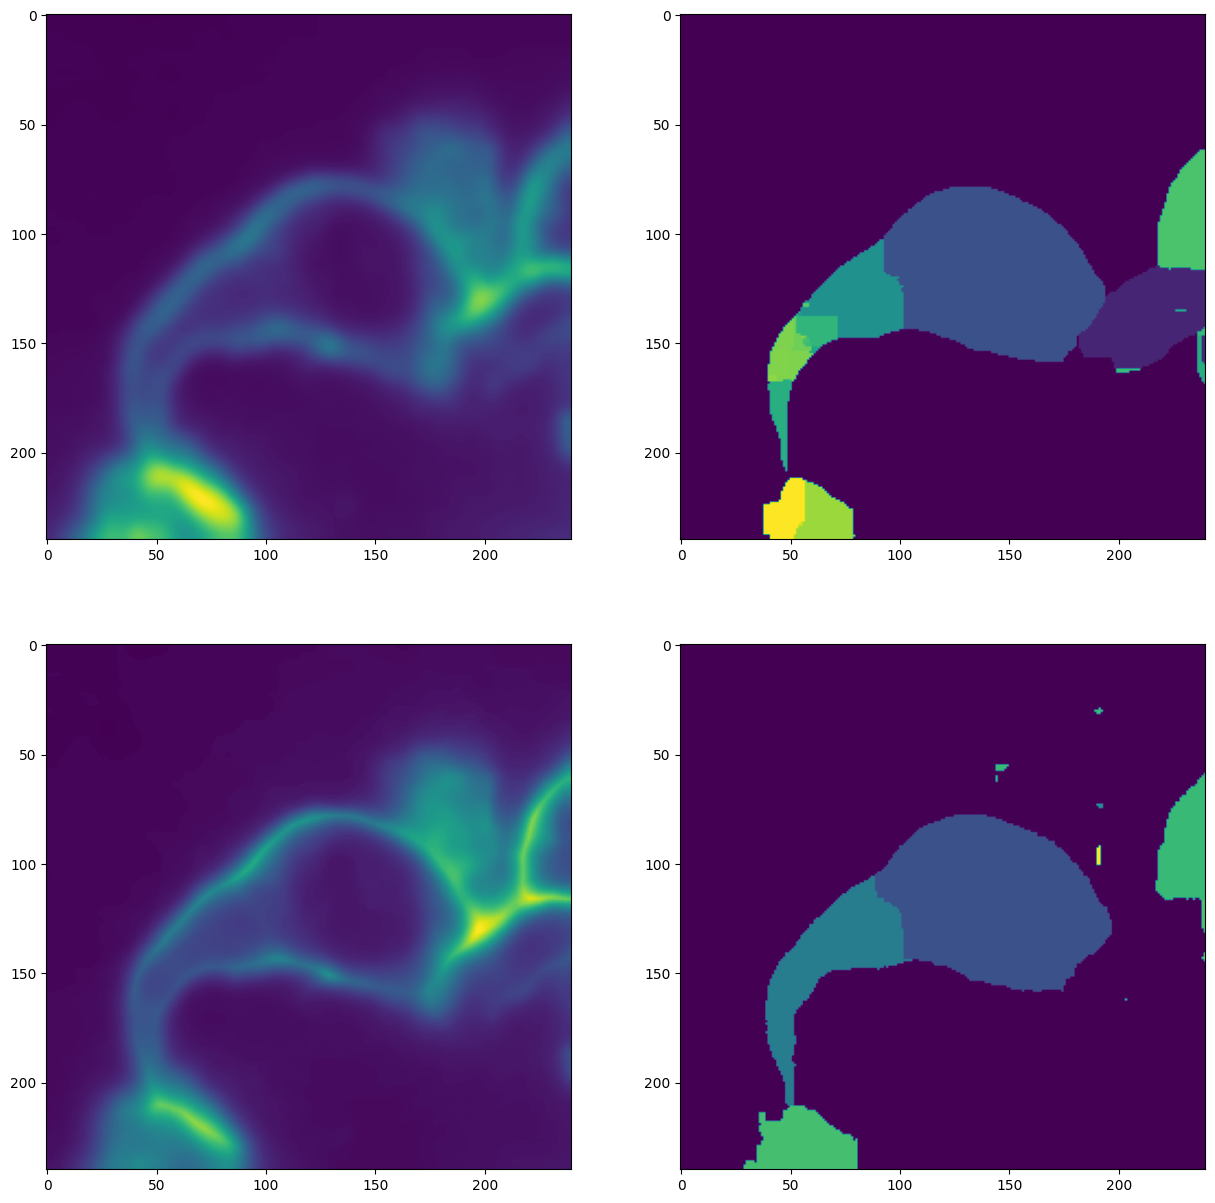

In [168]:
edges = copy(cell)
edges = ndi.gaussian_filter(edges, 3)
edges = rank.median(edges, ball(2)) # Can go before the gaussian_filter

edges = normalize_image(edges, 255).astype(np.uint8)


markers = rank.gradient(edges, ball(5)) < 10
markers = ndi.label(markers)[0]
labels = watershed(edges, markers) 


edt = ndi.distance_transform_edt(edges)
edt = reverse_values(edt)*edges
edt = sk.morphology.erosion(edt, footprint=ball(3))


edt = normalize_image(edt, 255).astype(np.uint8)
markers_edt = rank.gradient(edt, ball(5)) < 10
markers_edt = ndi.label(markers_edt)[0]
labels_edt = watershed(edt, markers_edt) # INstead of edt we can try with 'edges' Beause we just want the labels


plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(edges[delta])
plt.subplot(222)
plt.imshow(labels[delta])
plt.subplot(223)
plt.imshow(edt[delta])
plt.subplot(224)
plt.imshow(labels_edt[delta])

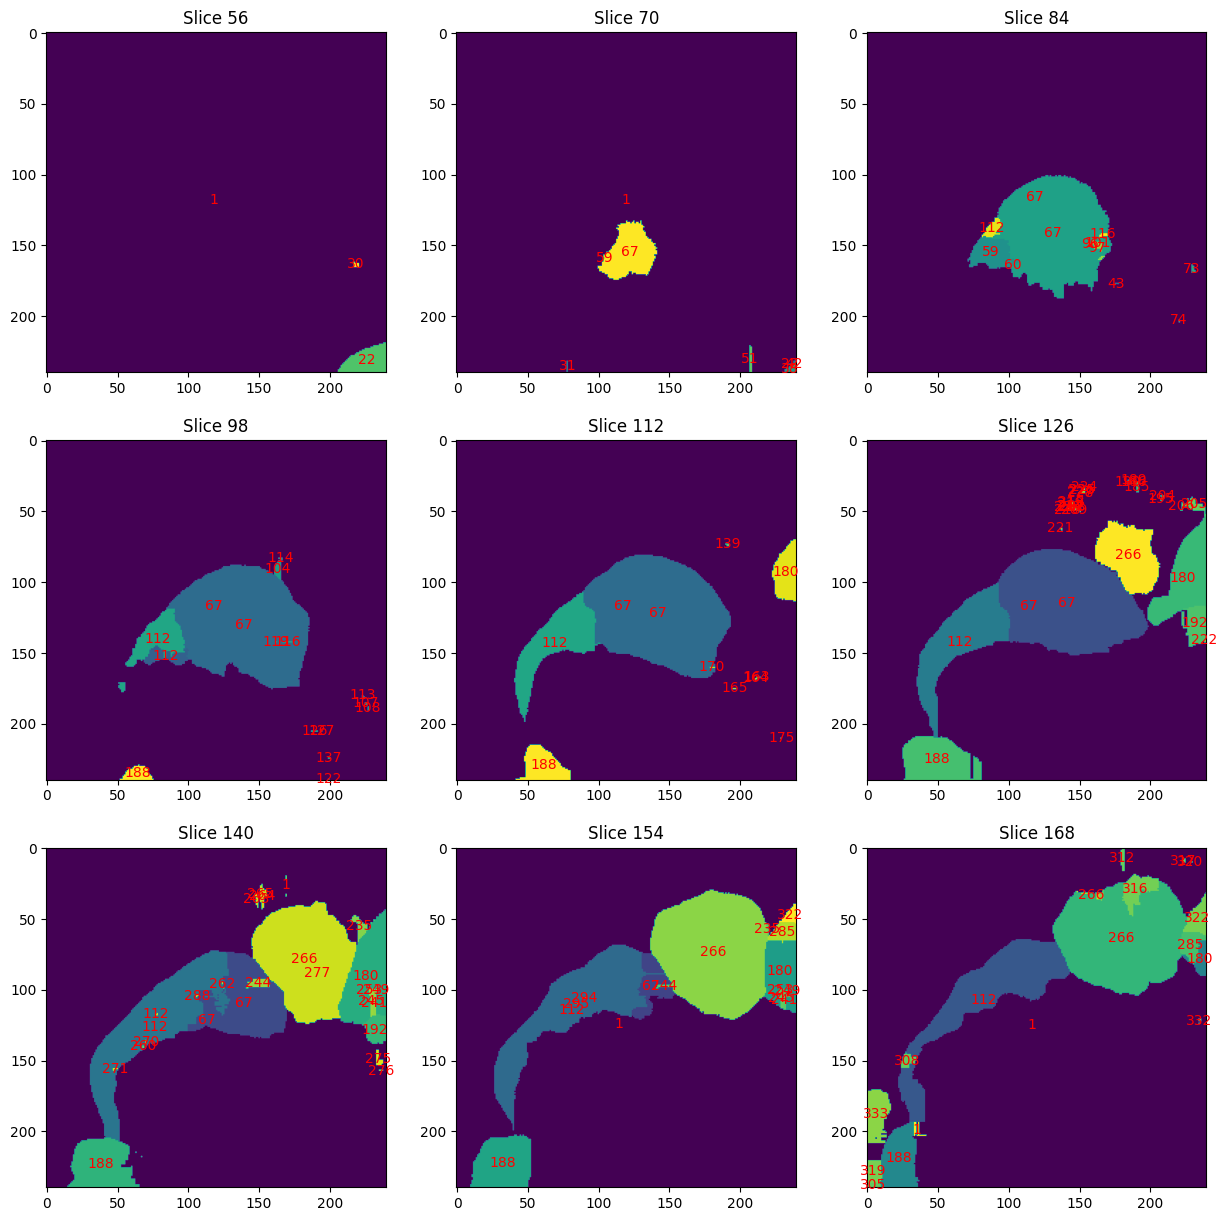

In [169]:
plt.figure(figsize=(15,15))
for i in range(9):
    slice = int(labels_edt.shape[0]/17)*(i+4)

    temp_labels = copy(labels_edt[slice])
    intensities = {}
    unique_temp_labels = np.unique(temp_labels)
    for temp_label in unique_temp_labels:
        temp_temp_label = copy(temp_labels)
        temp_temp_label[temp_temp_label != temp_label] = 0
        center = ndi.center_of_mass(temp_temp_label)
        intensities[temp_label] = center

    intensities = {k: (int(v[0]), int(v[1])) for k, v in intensities.items() if not any(np.isnan(coord) for coord in v)}

    plt.subplot(3,3,i+1)
    plt.imshow(temp_labels)
    plt.title(f"Slice {slice}")

    for center in intensities:
        center = intensities[center]
        plt.text(center[1], center[0], f'{temp_labels[int(center[0]), int(center[1])]}', ha='center', va='center', color='red')


# (((provar d'enganxar si no es esf√®ric)))


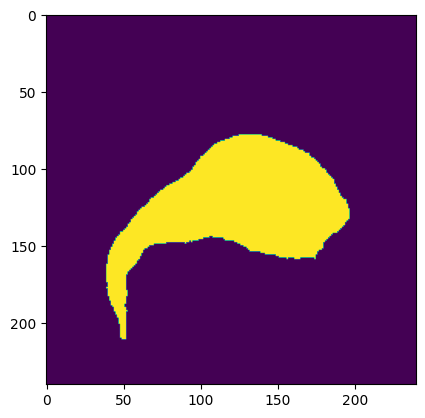

In [172]:
d3_masked_image = copy(labels_edt)
mask_numbers = [67, 112, 119, 176, 271, 270, 279, 310, 294, 244, 59, 308]
mask_complete = np.isin(d3_masked_image, mask_numbers)
d3_masked_image[~mask_complete] =  0
d3_masked_image[d3_masked_image!=0] = 1
d3_masked_image = sk.morphology.binary_closing(d3_masked_image, footprint=sk.morphology.ball(5))
d3_masked_image = d3_masked_image.astype(np.uint8)
plt.imshow(d3_masked_image[120])

In [173]:
tiff.imwrite('./../ppujol/cellstosegment/'+dome+'/temp_many_prov1.tif', d3_masked_image.astype(np.uint16), imagej=True)
# tiff.imwrite('./../ppujol/cellstosegment/'+dome+'/EdtImage.tif', normalize_image(edt, 65535).astype(np.uint16), imagej=True)

# End of _first_ mask search

We now have a manually precise mask of the cell ( __plain borders are not detected__ )

### Now we would have to extend the search and maybe keep the iteration se we find a better solution for the cell

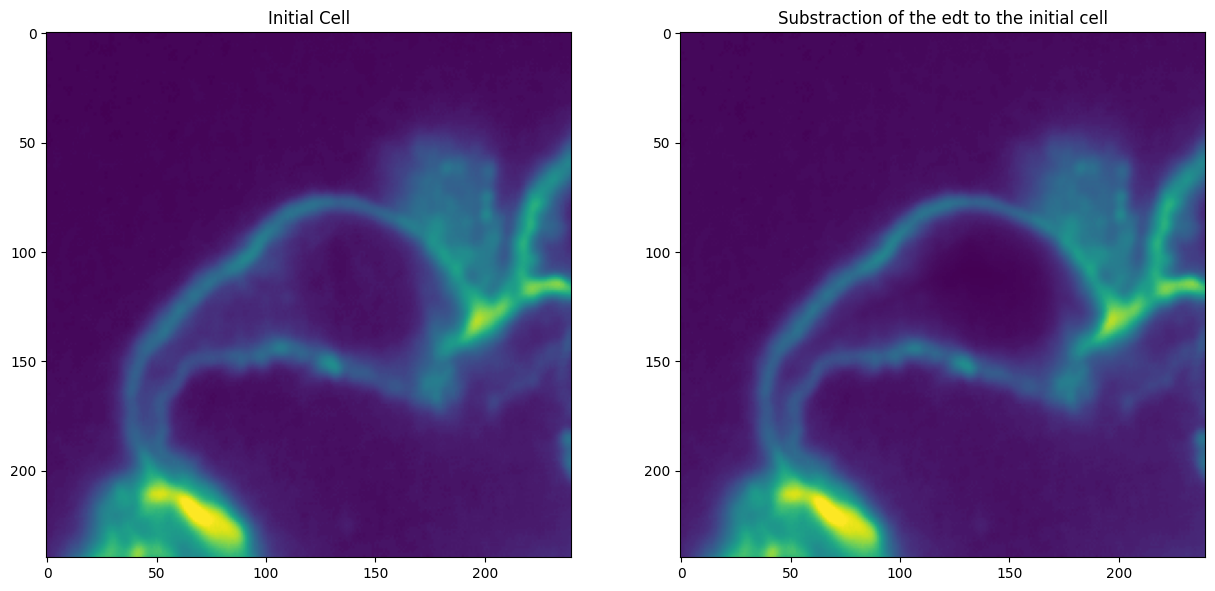

In [136]:
cell_2 = reverse_values(ndi.distance_transform_edt(d3_masked_image))*cell
cell_2 = normalize_image(cell_2, 255).astype(np.uint8)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title("Initial Cell")
plt.imshow(cell[120])
plt.subplot(222)
plt.title("Substraction of the edt to the initial cell")
plt.imshow(cell_2[120])

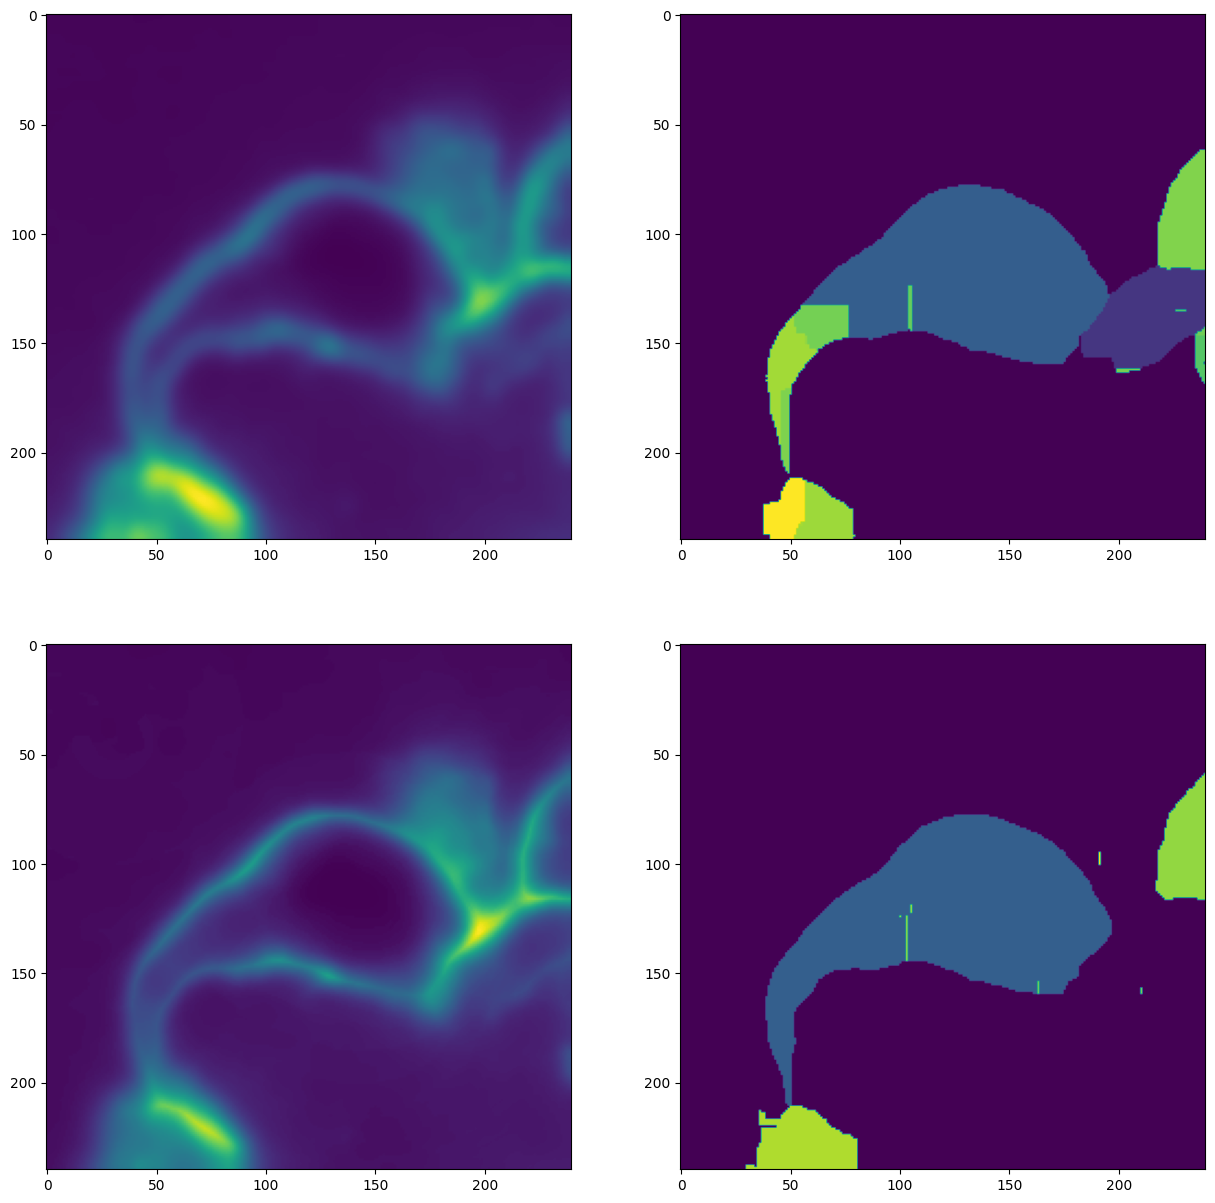

In [159]:
edges = copy(cell_2)
edges = ndi.gaussian_filter(edges, 3)
edges = rank.median(edges, ball(2)) # Can go before the gaussian_filter

edges = normalize_image(edges, 255).astype(np.uint8)


markers = rank.gradient(edges, ball(5)) < 10
markers = ndi.label(markers)[0]
labels = watershed(edges, markers) ### SUPER IMPORTANT TO DO THE LABELS ON THE ORIGINAL IMAGE TO GET THE MOST ACCURATED MASK. For the final


edt = ndi.distance_transform_edt(cell_2)
edt = reverse_values(edt)*edges
edt = sk.morphology.erosion(edt, footprint=ball(3))


edt = normalize_image(edt, 255).astype(np.uint8)
markers_edt = rank.gradient(edt, ball(5)) < 10
markers_edt = ndi.label(markers_edt)[0]
labels_edt = watershed(normalize_image(ndi.gaussian_filter(cell_2, 1), 255).astype(np.uint8), markers_edt) ### SUPER IMPORTANT TO DO THE LABELS ON THE ORIGINAL IMAGE TO GET THE MOST ACCURATED MASK. For the final


plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(edges[delta])
plt.subplot(222)
plt.imshow(labels[delta])
plt.subplot(223)
plt.imshow(edt[delta])
plt.subplot(224)
plt.imshow(labels_edt[delta])

[ 66  79  80  81  82  84  85  86  88  89 100 101 103 104 106 107 109 110
 113 115 153 159 165 169 173 183 184 185 186 188 189 193 194 196 197 200
 202 203 204 206 214 215 221 222 223 229 233 243 250 259 260 263 264 267
 272 273 277 278 290 293 303 311 326 353]


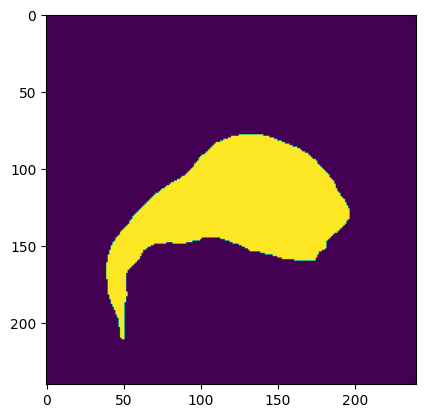

In [160]:
d3_masked_image_temp = sk.morphology.binary_erosion(d3_masked_image, footprint=sk.morphology.ball(5))
d3_masked_image_temp = d3_masked_image_temp.astype(np.uint8)

labels_in_cell_2 = d3_masked_image_temp*labels_edt
labels_in_cell_2 = np.unique(labels_in_cell_2)
mask = np.logical_and(labels_in_cell_2 != 0, labels_in_cell_2 != 1)
labels_in_cell_2 = labels_in_cell_2[mask]
print(labels_in_cell_2)
d3_masked_image_2 = copy(labels_edt)
mask_numbers = labels_in_cell_2
mask_complete = np.isin(d3_masked_image_2, mask_numbers)
d3_masked_image_2[~mask_complete] =  0
d3_masked_image_2[d3_masked_image_2!=0] = 1
# d3_masked_image = sk.morphology.binary_closing(d3_masked_image, footprint=sk.morphology.ball(5))
# d3_masked_image = d3_masked_image.astype(np.uint8)
plt.imshow(d3_masked_image_2[120])

In [161]:
tiff.imwrite('./../ppujol/cellstosegment/'+dome+'/temp_many_prov_all_labels_second.tif', d3_masked_image_2.astype(np.uint16), imagej=True)

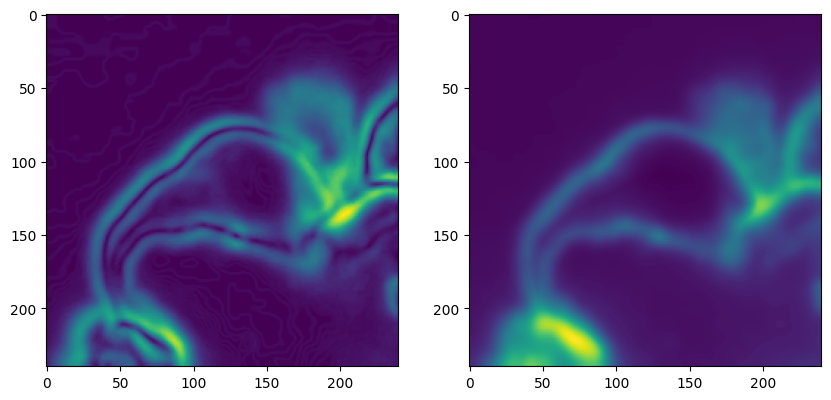

In [108]:
edges_sobel = sobel(edges)
edges_sobel = normalize_image(edges_sobel)
mask_x_image = d3_masked_image*normalize_image(edges)
edt_masked = ndi.distance_transform_edt(mask_x_image)

cell_2 = reverse_values(ndi.distance_transform_edt(d3_masked_image))*edges # edges or edges_sobel
cell_2 = normalize_image(cell_2, 255).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(edges_sobel[120])
plt.subplot(122)
plt.imshow(cell_2[120])

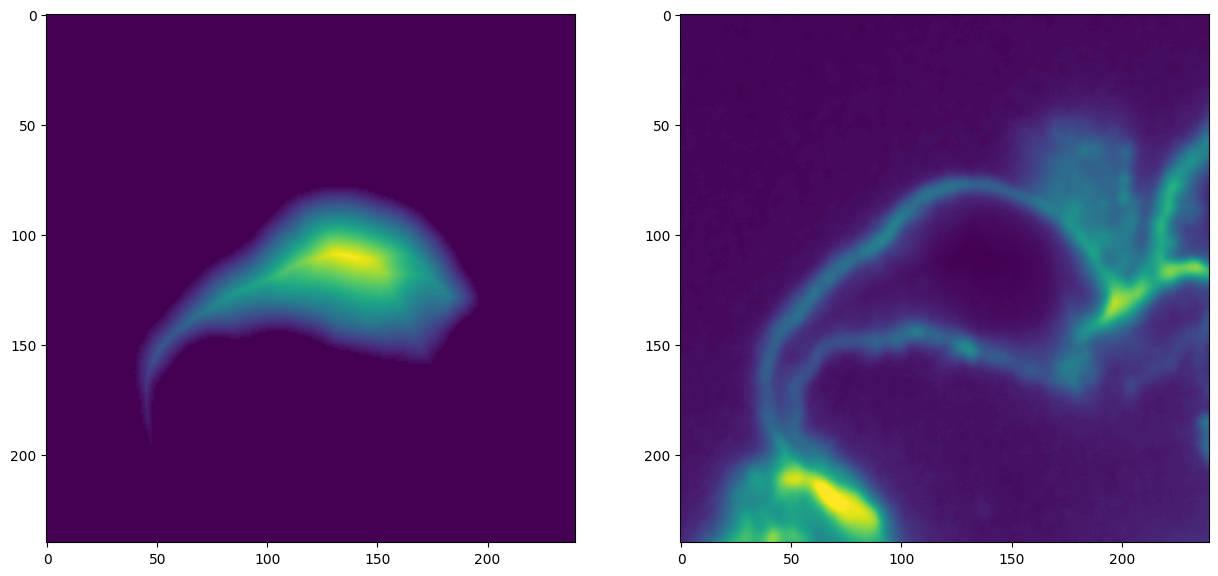

In [124]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(ndi.distance_transform_edt(d3_masked_image)[120])
plt.subplot(122)
plt.imshow((reverse_values(ndi.distance_transform_edt(d3_masked_image))*cell)[120])

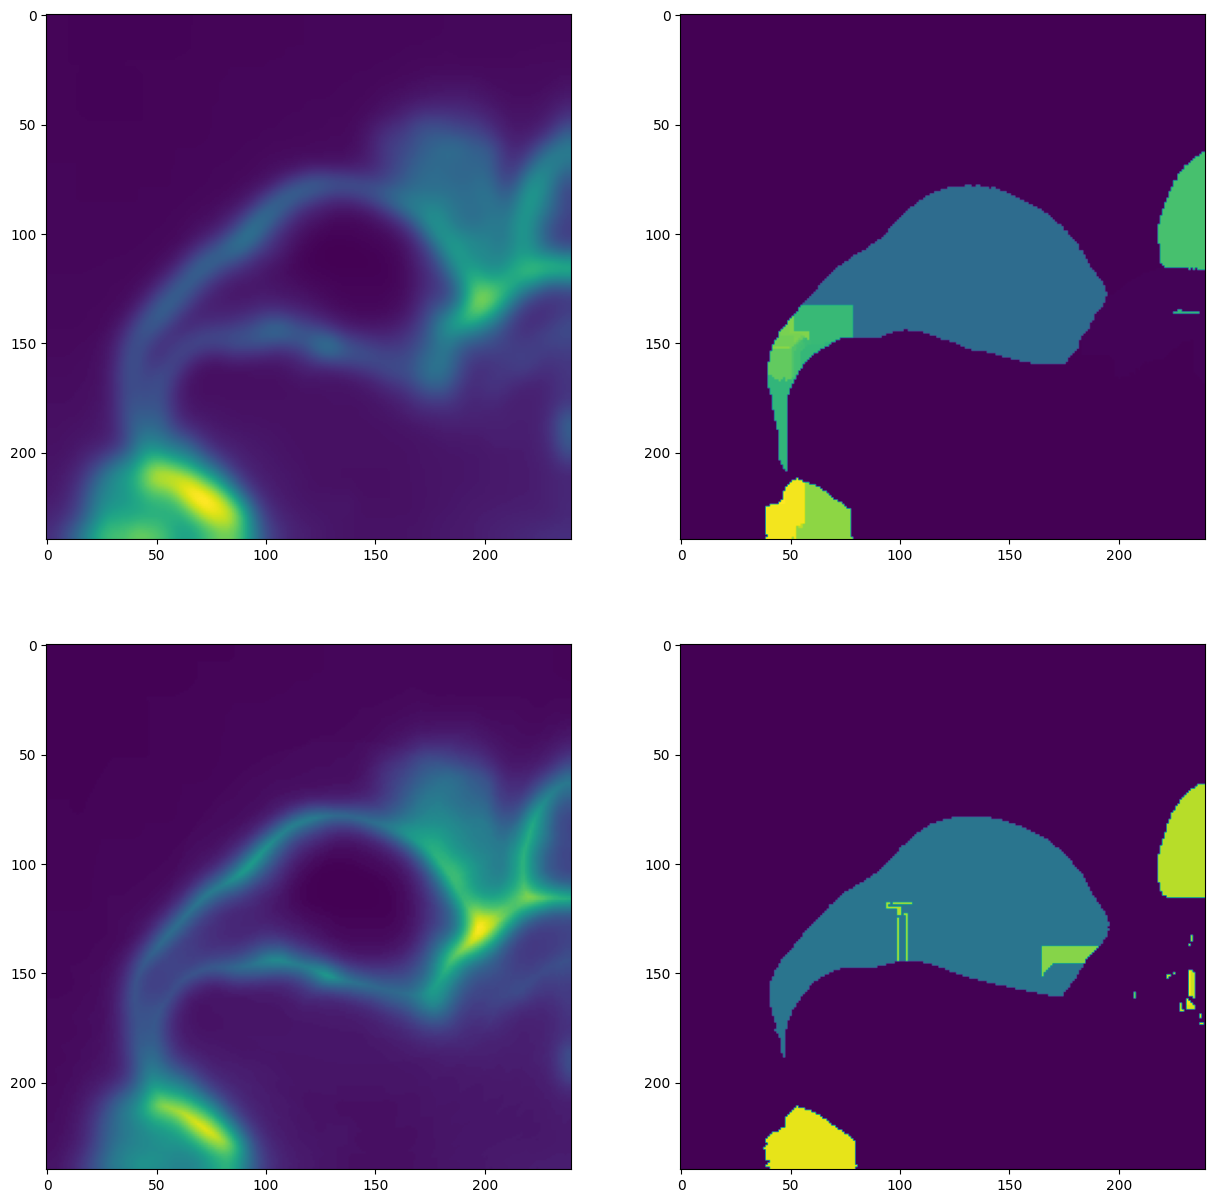

In [115]:
# can also do the sobel edge filter to search for the edges and plain borders
edges = copy(cell_2)
edges = ndi.gaussian_filter(edges, 3)
edges = rank.median(edges, ball(2)) # Can go before the gaussian_filter

edges = normalize_image(edges, 255).astype(np.uint8)


markers = rank.gradient(edges, ball(5)) < 10
markers = ndi.label(markers)[0]
labels = watershed(edges, markers) 


edt = ndi.distance_transform_edt(edges)
edt = reverse_values(edt)*edges
edt = sk.morphology.erosion(edt, footprint=ball(3))


edt = normalize_image(edt, 255).astype(np.uint8)
markers_edt = rank.gradient(edt, ball(5)) < 10
markers_edt = ndi.label(markers_edt)[0]
labels_edt = watershed(edt, markers_edt) 


plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(edges[delta])
plt.subplot(222)
plt.imshow(labels[delta])
plt.subplot(223)
plt.imshow(edt[delta])
plt.subplot(224)
plt.imshow(labels_edt[delta])


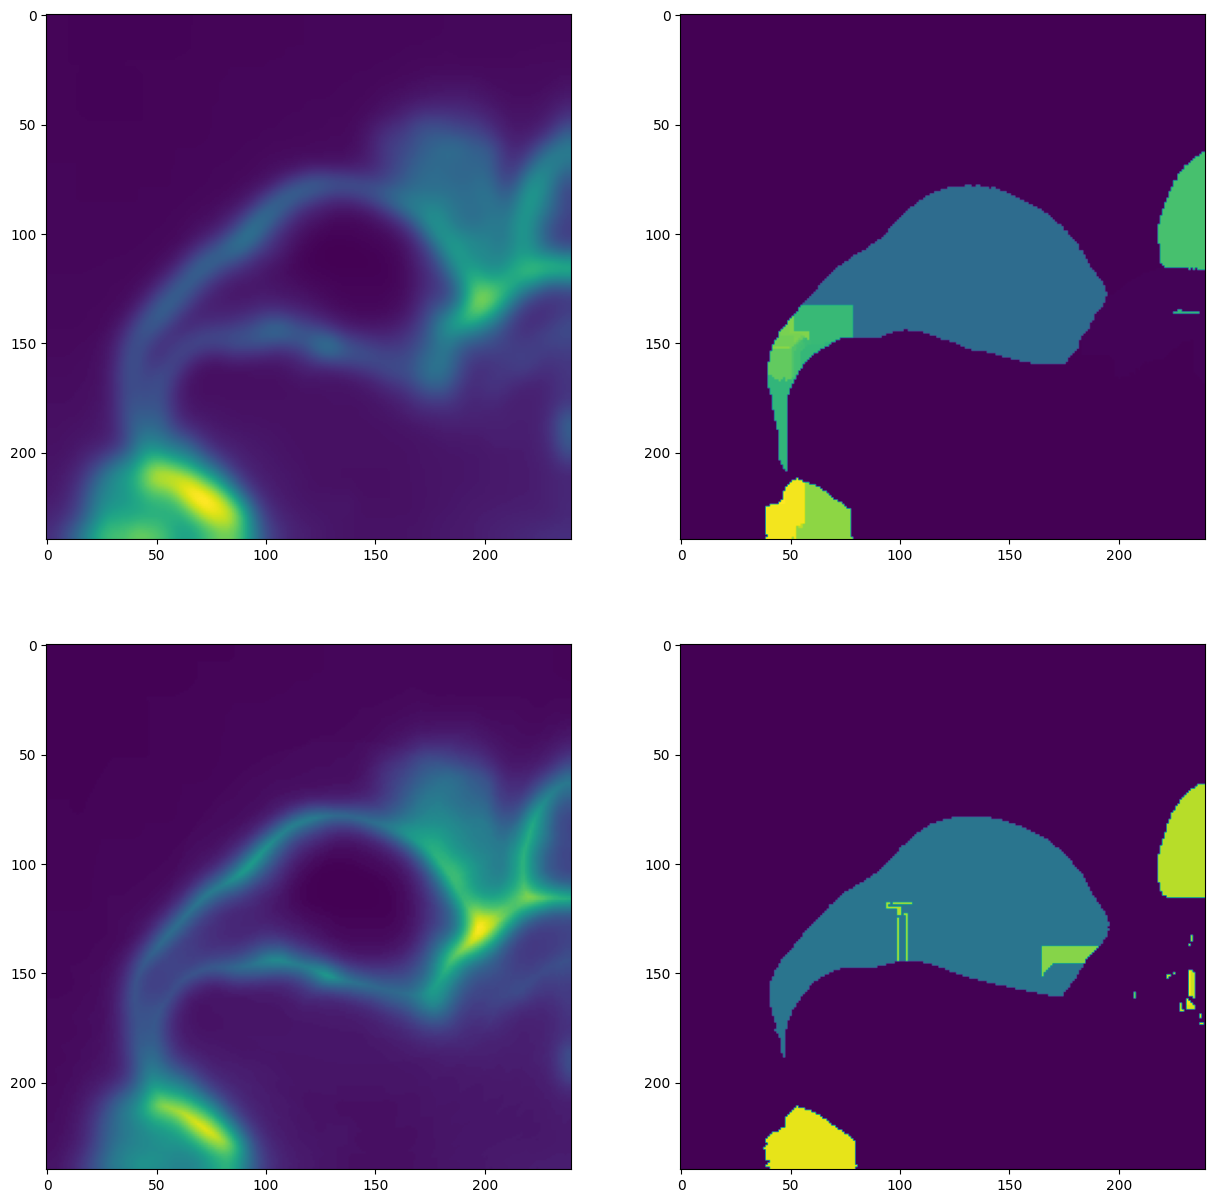

In [116]:
h = 188
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(edges[h])
plt.subplot(222)
plt.imshow(labels[h])
plt.subplot(223)
plt.imshow(edt[h])
plt.subplot(224)
plt.imshow(labels_edt[h])

In [71]:
# tiff.imwrite('./../ppujol/cellstosegment/'+dome+'/temp_many_prov1_2.tif', labels_edt.astype(np.uint16), imagej=True)

# Final prova